In [ ]:
from sklearn.datasets import fetch_lfw_people, fetch_lfw_pairs

data = fetch_lfw_people(min_faces_per_person=20, color=True)

In [ ]:
!pip install -q git+https://github.com/rcmalli/keras-vggface.git
!pip install -q mtcnn
!pip install -q keras_applications --no-deps

filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

     |████████████████████████████████| 2.3 MB 32.8 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 


In [ ]:
import cv2
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN # helps to detect and crop faces, not needed here as we already have faces 
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import trange
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def is_match(known_emb, inp_emb, thresh=0.5):
    score = cosine(known_emb, inp_emb)
    return 1 if score <= thresh else 0

In [ ]:
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
num_samples = len(data['target'])
num_samples

3023

In [ ]:
data_imgs = []

for i in range(num_samples):
    img = data['images'][i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    data_imgs.append(img)
    
data_imgs = np.array(data_imgs)
input_shape = data_imgs[0].shape
input_shape

(224, 224, 3)

In [ ]:
indices = np.arange(num_samples)
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=True, random_state=123)

In [ ]:
model = VGGFace(model='senet50', include_top=False, input_shape=input_shape, pooling='avg')

104955904/104944616 [==============================] - 1s 0us/step


In [ ]:
data_imgs[train_idx].shape, data['target_names'][data['target'][test_idx][np.random.randint(len(test_idx))]]

((2720, 224, 224, 3), 'Arnold Schwarzenegger')

Checking for: Bill Clinton


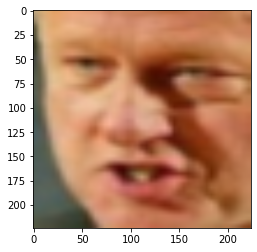

  0%|          | 0/2720 [00:00<?, ?it/s]

,Ground Truth,Predicted
0,Bill Clinton,Bill Clinton


In [ ]:
dict_names = {}
test_person = data['target'][test_idx][55]
test_person_name = data['target_names'][data['target'][test_idx][55]]
print(f"Checking for: {test_person_name}")
plt.imshow(cv2.cvtColor(data_imgs[test_idx][55]/255., cv2.COLOR_BGR2RGB))
plt.show()

temp_df = pd.DataFrame(data=np.zeros(shape=(1,2)), columns=['Ground Truth', 'Predicted'])
temp_df.iloc[0, 0] = test_person_name

test_person_img = data_imgs[test_idx][55]
imageA = test_person_img.reshape(1, 224, 224, 3).astype(np.float32)
imageA = preprocess_input(imageA, version=2)
encodingA = model.predict(imageA)

for i in trange(len(train_idx), leave=False):
    person_name = data['target_names'][data['target'][train_idx][i]]
    img_array = data_imgs[train_idx][i]
    imageB = img_array.reshape(1, 224, 224, 3).astype(np.float32)
    imageB = preprocess_input(imageB, version=2)
    encodingB = model.predict(imageB)
    similar = is_match(encodingB, encodingA)
    if dict_names.get(person_name) is not None:
        dict_names[person_name] += similar
    else:
        dict_names[person_name] = similar
unrecognized = max(list(dict_names.values())) < 1
if unrecognized:
    pred_name = 'Unknown'
else:
    pred_name = max(dict_names, key=dict_names.get)
temp_df.iloc[0, 1] = pred_name
temp_df

In [ ]:
sorted(dict_names.items(), reverse=True, key=lambda x: x[1])

[('Bill Clinton', 27),
 ('Ricardo Lagos', 22),
 ('George W Bush', 11),
 ('Igor Ivanov', 9),
 ('Tom Ridge', 9),
 ('Jean Chretien', 8),
 ('Colin Powell', 7),
 ('Ariel Sharon', 5),
 ('Hugo Chavez', 3),
 ('Gray Davis', 2),
 ('Hans Blix', 2),
 ('George Robertson', 2),
 ('Arnold Schwarzenegger', 1),
 ('Vladimir Putin', 1),
 ('Atal Bihari Vajpayee', 1),
 ('Serena Williams', 0),
 ('Gerhard Schroeder', 0),
 ('Recep Tayyip Erdogan', 0),
 ('Amelie Mauresmo', 0),
 ('Megawati Sukarnoputri', 0),
 ('Tony Blair', 0),
 ('Nestor Kirchner', 0),
 ('Jose Maria Aznar', 0),
 ('Donald Rumsfeld', 0),
 ('Kofi Annan', 0),
 ('David Beckham', 0),
 ('John Negroponte', 0),
 ('Silvio Berlusconi', 0),
 ('Tom Daschle', 0),
 ('Jacques Chirac', 0),
 ('Mahmoud Abbas', 0),
 ('Roh Moo-hyun', 0),
 ('John Ashcroft', 0),
 ('Vicente Fox', 0),
 ('Luiz Inacio Lula da Silva', 0),
 ('Lleyton Hewitt', 0),
 ('Guillermo Coria', 0),
 ('Jack Straw', 0),
 ('Jennifer Lopez', 0),
 ('Lindsay Davenport', 0),
 ('Hamid Karzai', 0),
 ('Angelina